### VUB-ML-2023-Predicting-Energy-Consumption

Define your folder structure with your data:

In [1]:
# numerical library:
import numpy as np

# data manipulation library:
import pandas as pd

# standard packages used to handle files:
import sys
import os 
import glob
import time

# scikit-learn machine learning library:
import sklearn

# plotting:
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from matplotlib import patches
import seaborn as sns
from sklearn.preprocessing import PowerTransformer,FunctionTransformer,StandardScaler
from sklearn.model_selection import train_test_split
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error,make_scorer
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint



import warnings
warnings.filterwarnings("ignore", category=UserWarning)


# tell matplotlib that we plot in a notebook:
# %matplotlib notebook

In [2]:
data_folder = "./"

In [3]:
train_data = pd.read_csv(data_folder + "train.csv")
test_data = pd.read_csv(data_folder + "test.csv")

### Data exploration
Let's take a look at our train and test data:

In [4]:
test_data.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-04-24 21:00:00,0,21.926667,35.5,19.2900,37.500000,22.39,34.000000,21.39,32.225714,...,20.200000,32.400000,4.10,758.00,82.000000,3.0,40.0,1.2,10.668196,10.668196
1,2016-04-24 21:10:00,0,21.890000,35.4,19.2225,37.425000,22.39,34.090000,21.35,32.200000,...,20.200000,32.400000,3.95,758.05,82.166667,3.0,40.0,1.1,48.467852,48.467852
2,2016-04-24 21:20:00,0,21.890000,35.4,19.2000,37.466667,22.39,33.963333,21.29,32.277143,...,20.200000,32.290000,3.80,758.10,82.333333,3.0,40.0,1.0,36.388536,36.388536
3,2016-04-24 21:30:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.900000,21.29,32.334000,...,20.175000,32.290000,3.65,758.15,82.500000,3.0,40.0,0.9,17.198176,17.198176
4,2016-04-24 21:40:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.966667,21.29,32.290000,...,20.166667,32.563333,3.50,758.20,82.666667,3.0,40.0,0.8,7.200588,7.200588


In [5]:
train_data.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,50
4,2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [6]:
train_data.dtypes

date            object
lights           int64
T1             float64
RH_1           float64
T2             float64
RH_2           float64
T3             float64
RH_3           float64
T4             float64
RH_4           float64
T5             float64
RH_5           float64
T6             float64
RH_6           float64
T7             float64
RH_7           float64
T8             float64
RH_8           float64
T9             float64
RH_9           float64
T_out          float64
Press_mm_hg    float64
RH_out         float64
Windspeed      float64
Visibility     float64
Tdewpoint      float64
rv1            float64
rv2            float64
Appliances       int64
dtype: object

Let's take a look at our first 1000 datapoints in the training set:

In [7]:
train_data.describe()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,...,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,4.389333,21.150644,40.223645,19.658822,40.688595,21.563270,39.545294,20.136782,39.118823,18.938388,...,41.669635,5.904323,755.512243,81.749333,4.299733,38.760367,2.761777,24.989925,24.989925,98.751333
std,8.453314,1.235377,3.570557,1.524552,3.387494,1.525732,3.149775,1.540814,4.269767,1.318223,...,3.958103,4.189812,7.928961,12.980934,2.589470,12.570409,3.577249,14.508441,14.508441,106.421877
min,0.000000,16.790000,27.733333,16.100000,25.763333,17.200000,32.626667,15.100000,27.660000,15.330000,...,31.033333,-5.000000,729.300000,31.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,10.000000
25%,0.000000,20.390000,37.590000,18.600000,38.400000,20.463333,37.230000,19.166667,35.700000,18.000000,...,38.700000,2.983333,750.650000,73.000000,2.000000,29.000000,0.366667,12.566582,12.566582,50.000000
50%,0.000000,21.290000,39.790000,19.600000,40.760000,21.600000,38.831667,20.206481,38.500000,18.890000,...,40.966667,5.850000,756.166667,85.250000,4.000000,40.000000,2.833333,24.858659,24.858659,60.000000
75%,10.000000,22.033333,42.933333,20.666667,43.290000,22.600000,42.000000,21.260000,42.090000,20.000000,...,44.246607,8.966667,761.766667,92.000000,6.000000,40.000000,5.300000,37.675790,37.675790,100.000000
max,70.000000,24.100000,63.360000,24.600000,56.026667,27.600000,50.163333,23.760000,51.090000,22.967778,...,53.326667,19.700000,772.300000,100.000000,14.000000,66.000000,11.400000,49.996530,49.996530,1080.000000


In [8]:
train_data_temp = train_data.copy()
# Drop the date column
train_data_temp = train_data_temp.drop(["date"], axis=1)
train_data_temp.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,50
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389,50
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097,60


In [9]:
train_data_temp.corr()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances
lights,1.000000,0.092859,0.149226,0.123325,0.051636,-0.017164,0.150710,0.116495,0.131148,0.005402,...,0.001526,-0.013318,-0.009154,0.047729,0.037738,0.015345,0.021450,-0.003072,-0.003072,0.223585
T1,0.092859,1.000000,0.022486,0.770547,-0.015411,0.816525,-0.089806,0.752710,-0.010284,0.797897,...,-0.055826,0.441579,-0.149507,-0.254685,0.049154,-0.054255,0.322605,-0.005087,-0.005087,0.087258
RH_1,0.149226,0.022486,1.000000,0.264038,0.790911,0.121259,0.837415,-0.082896,0.855006,0.067733,...,0.715624,0.361673,-0.251135,0.258274,0.306311,-0.020426,0.605811,-0.003434,-0.003434,0.090329
T2,0.123325,0.770547,0.264038,1.000000,-0.111158,0.575122,0.204770,0.573002,0.258420,0.565379,...,0.145629,0.597790,-0.150003,-0.393215,0.251975,-0.065477,0.400001,-0.005526,-0.005526,0.157046
RH_2,0.051636,-0.015411,0.790911,-0.111158,1.000000,0.173080,0.631004,-0.086679,0.700076,0.144692,...,0.629805,0.202693,-0.223372,0.492143,0.125635,0.001125,0.593173,-0.001154,-0.001154,-0.059584
T3,-0.017164,0.816525,0.121259,0.575122,0.173080,1.000000,-0.099201,0.727089,-0.010335,0.821112,...,0.002376,0.508110,-0.216960,-0.230845,0.051684,-0.095963,0.418853,-0.003196,-0.003196,0.126482
RH_3,0.150710,-0.089806,0.837415,0.204770,0.631004,-0.099201,1.000000,-0.271640,0.902797,-0.142442,...,0.829494,0.149804,-0.183498,0.345917,0.335664,0.008168,0.419339,-0.002117,-0.002117,0.034468
T4,0.116495,0.752710,-0.082896,0.573002,-0.086679,0.727089,-0.271640,1.000000,-0.246150,0.752717,...,-0.222248,0.404930,-0.038604,-0.355113,-0.096428,-0.095548,0.207633,0.000881,0.000881,0.074127
RH_4,0.131148,-0.010284,0.855006,0.258420,0.700076,-0.010335,0.902797,-0.246150,1.000000,-0.029515,...,0.850997,0.322947,-0.203515,0.350118,0.382819,0.008836,0.622001,-0.003560,-0.003560,-0.001280
T5,0.005402,0.797897,0.067733,0.565379,0.144692,0.821112,-0.142442,0.752717,-0.029515,1.000000,...,-0.069337,0.437593,-0.203299,-0.187191,-0.047250,-0.065828,0.365980,-0.007865,-0.007865,0.034020


In [10]:
# lights , T2,T3 T6,RH_out are high corelated with Appliances
train_data_temp.corrwith(train_data_temp["Appliances"])

lights         0.223585
T1             0.087258
RH_1           0.090329
T2             0.157046
RH_2          -0.059584
T3             0.126482
RH_3           0.034468
T4             0.074127
RH_4          -0.001280
T5             0.034020
RH_5          -0.003534
T6             0.118191
RH_6          -0.081692
T7             0.052300
RH_7          -0.069853
T8             0.070779
RH_8          -0.115603
T9             0.027337
RH_9          -0.062399
T_out          0.102267
Press_mm_hg   -0.041420
RH_out        -0.148025
Windspeed      0.076209
Visibility    -0.007147
Tdewpoint      0.015312
rv1           -0.008751
rv2           -0.008751
Appliances     1.000000
dtype: float64

In [11]:
# T_out and T6 high corelation 
corr_matrix = train_data_temp.corr()


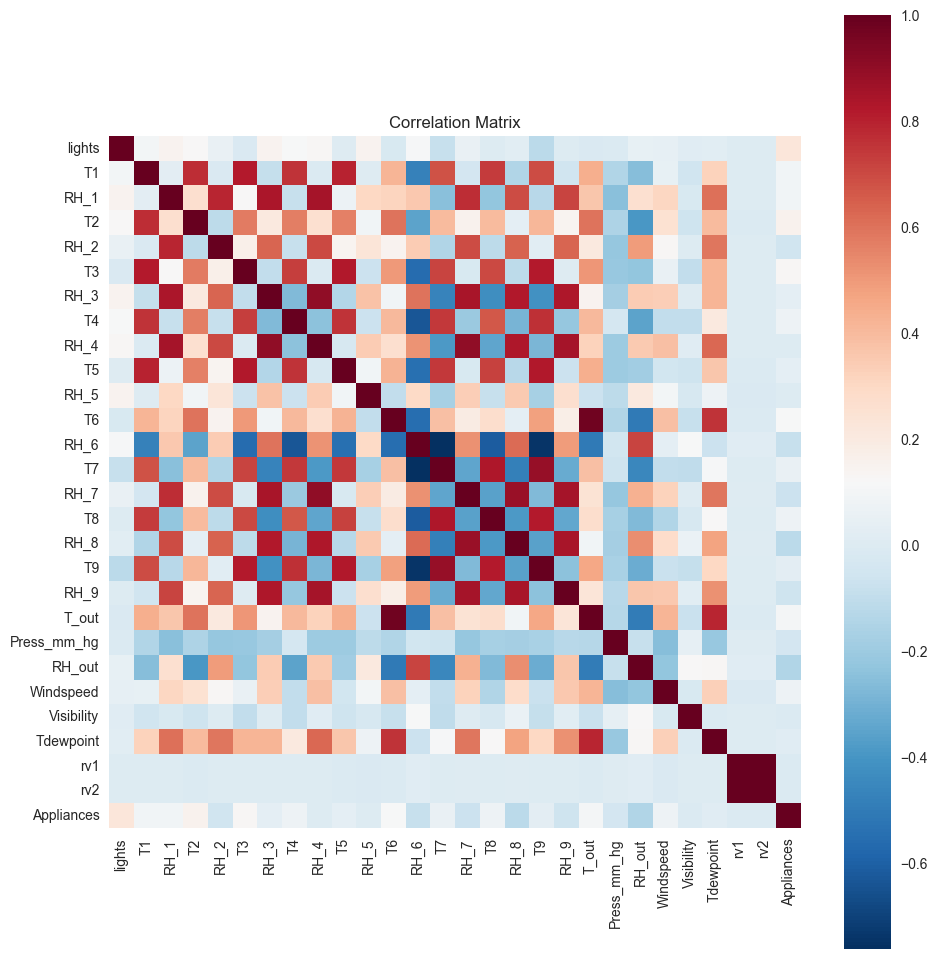

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", square=True, cmap='RdBu_r')  
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

### RH_out light are skewed T1,RH_1,T2,RH2 data are normaly distributed
Plot histograms with a specified layout and size

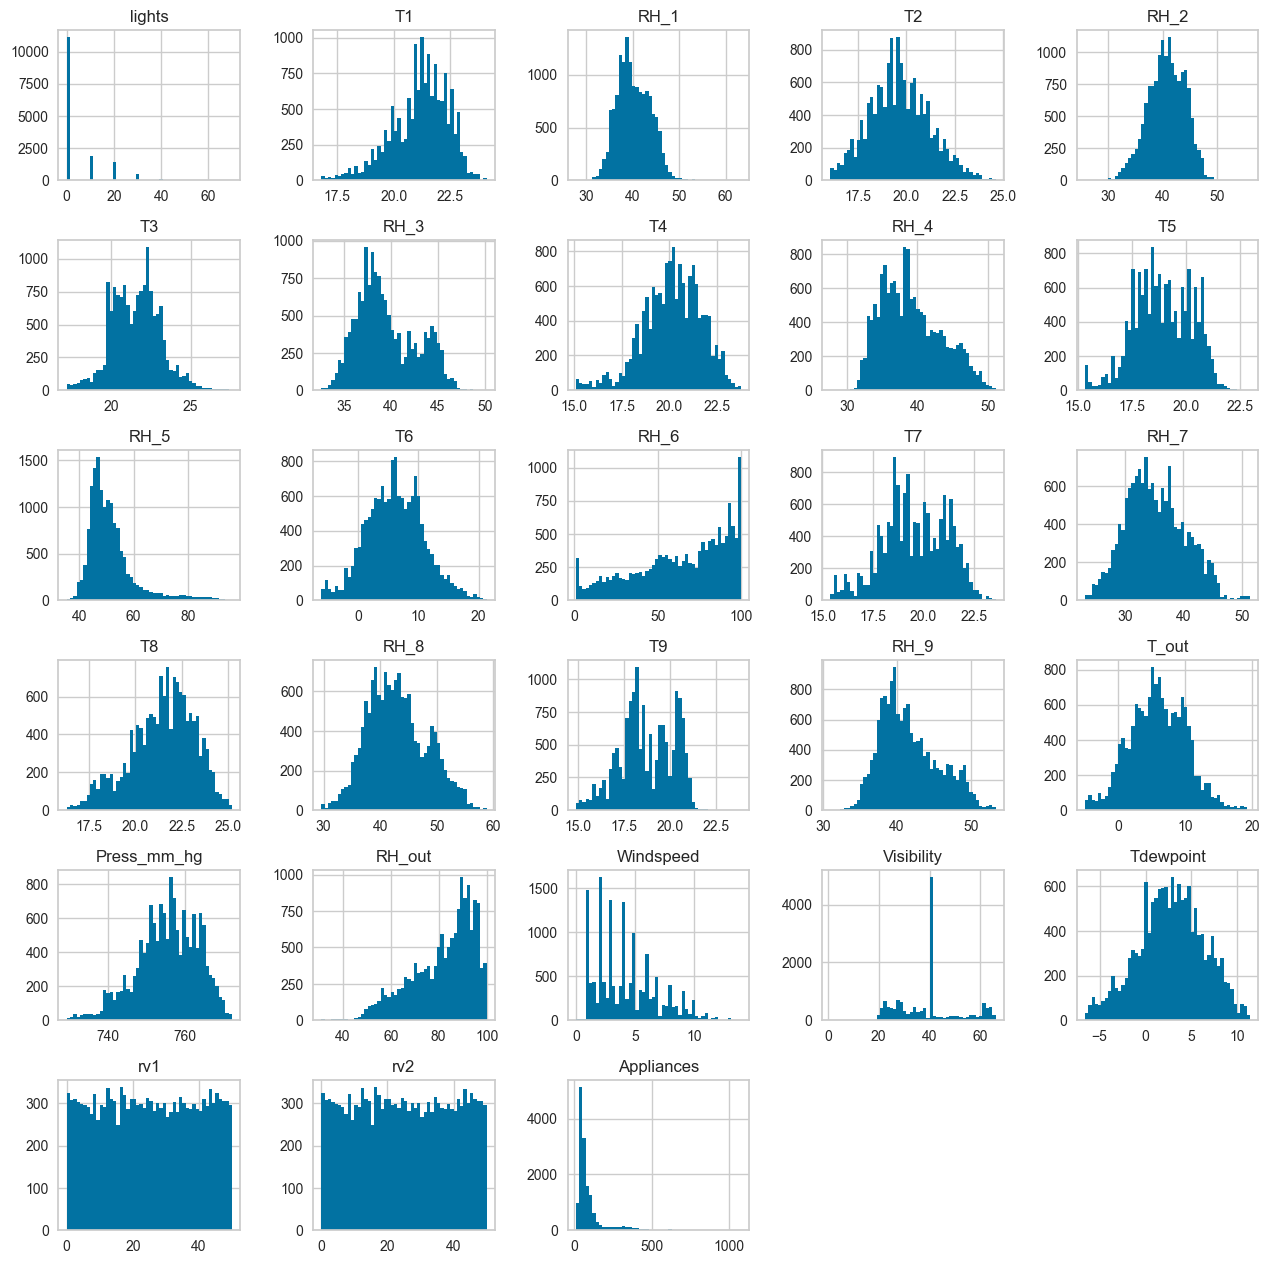

In [13]:

train_data_temp.hist(bins=50, figsize=(15, 15))

# Add margins around each histogram using subplots_adjust
plt.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.9, wspace=0.4, hspace=0.4)

plt.show()

## Lights
On average 60 Wh light is high, when the energy usage of the lights is 60 Wh (watt-hours), the energy usage of the appliances in the house is around 600 Wh.

However, this does not mean that the light fixtures themselves are high energy consumers or that they are directly responsible for the energy usage of the appliances. lights and Appliances are measurements of different systems within the house.

<Axes: xlabel='lights'>

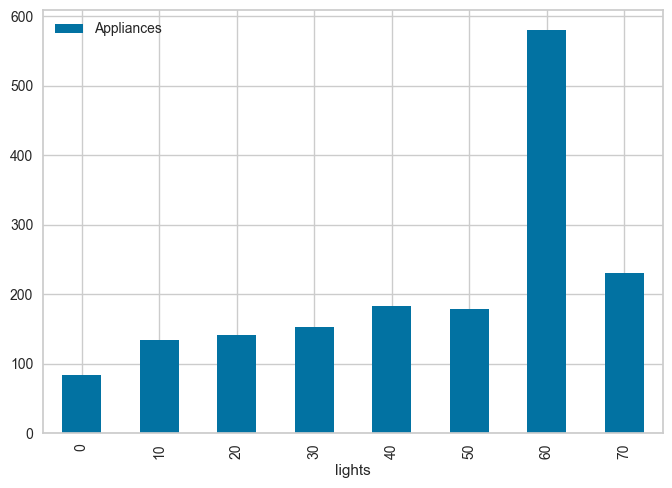

In [14]:
train_data_temp.loc[:, ["lights", "Appliances"]].groupby("lights").mean().plot.bar()

## T1

T1, Temperature in kitchen area, in Celsius

When the kitchen temperature T1 is colder around 16-17 degrees Celsius the average energy consumption of appliances tends to be higher (around 140 Wh). This might be because heating appliances or others like ovens are used more. On the other hand, when the kitchen is warmer around 22-23 degrees Celsius, the average energy consumption of appliances decreases to around 120 Wh, possibly because heating appliances are used less or other appliances are used more efficiently.

Minimum value of T1: 16.79
Maximum value of T1: 24.1


<Axes: xlabel='T1_binned'>

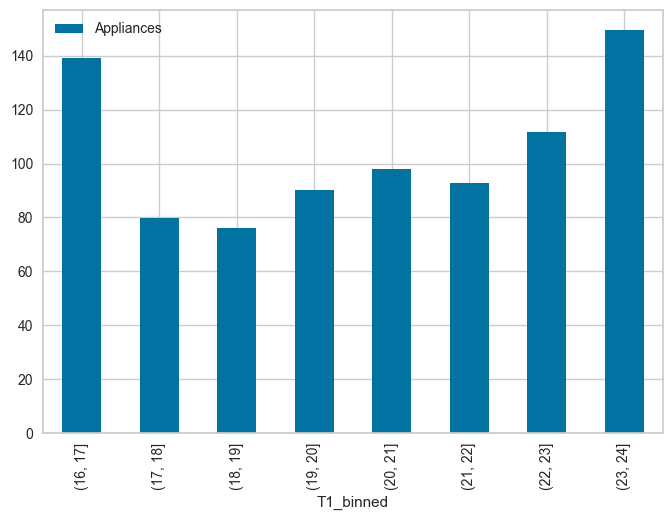

In [15]:
min_T1 = train_data_temp['T1'].min()
max_T1 = train_data_temp['T1'].max()

print(f"Minimum value of T1: {min_T1}")
print(f"Maximum value of T1: {max_T1}")

# Bin edges.
bin_edges = np.arange(16, 25, 1) # Fixed bin size of 1
# Bin the data into discrete intervals.
train_data_temp['T1_binned'] = pd.cut(train_data_temp['T1'], bins=bin_edges)

# Average Appliances energy use for each bin.
train_data_temp.loc[:, ["T1_binned", "Appliances"]].groupby("T1_binned").mean().plot.bar()


## RH_1

RH_1, Humidity in kitchen area, in %

When the kitchen humidity is lower (27-29%), appliances use more energy (175 Wh). When it's more humid (57-59%), they use less energy (100 Wh).

This could be due to various factors, such as increased use of dehumidifiers or air conditioning, or changes in how other appliances perform under these conditions.



Minimum value of RH_1: 27.73333333333329
Maximum value of RH_1: 63.36


<Axes: xlabel='RH_1_binned'>

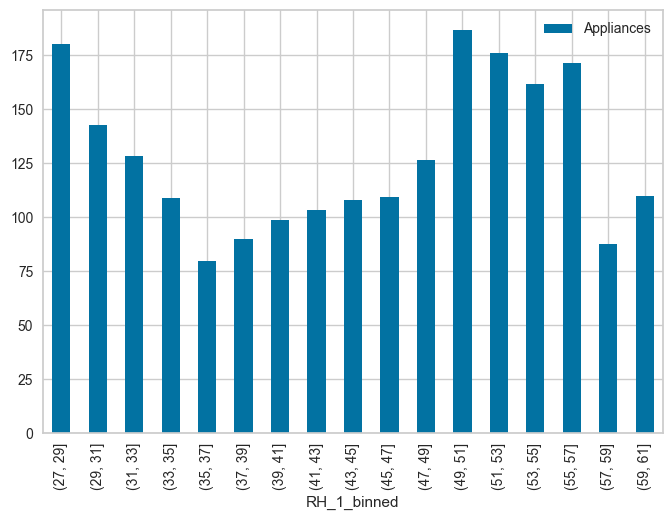

In [16]:
min_RH_1 = train_data_temp['RH_1'].min()
max_RH_1 = train_data_temp['RH_1'].max()

print(f"Minimum value of RH_1: {min_RH_1}")
print(f"Maximum value of RH_1: {max_RH_1}")

bin_edges = np.arange(27, 63, 2) 
train_data_temp['RH_1_binned'] = pd.cut(train_data_temp['RH_1'], bins=bin_edges)

train_data_temp.loc[:, ["RH_1_binned", "Appliances"]].groupby("RH_1_binned").mean().plot.bar()


## T2

T2, Temperature in living room area, in Celsius

When the temperature between 16-18 degrees appliances use less energy around 70-80 Wh. This might be because less energy needed for heating or cooling. However when the temperature increases to between 22-23 degrees the energy usage of appliances increases to about 150 Wh. This could be due to increased use of cooling appliances like air conditioners or fans.

In [ ]:
min_T2 = train_data_temp['T2'].min()
max_T2 = train_data_temp['T2'].max()

print(f"Minimum value of T2: {min_T2}")
print(f"Maximum value of T2: {max_T2}")

bin_edges = np.arange(16, 24, 1)
train_data_temp['T2_binned'] = pd.cut(train_data_temp['T2'], bins=bin_edges)

train_data_temp.loc[:, ["T2_binned", "Appliances"]].groupby("T2_binned").mean().plot.bar()


## RH_2

RH_2, Humidity in living room area, in %

As humidity in the living room changes from low (25-30%) to moderate (45-50%) to high (50-55%) appliance energy usage first decreases from 175 Wh to 100 Wh then increases back up to 200 Wh possibly indicating the use of appliances to manage excessive humidity such as air conditioners or dehumidifiers.

In [ ]:
min_RH_2 = train_data_temp['RH_2'].min()
max_RH_2 = train_data_temp['RH_2'].max()

print(f"Minimum value of RH_2: {min_RH_2}")
print(f"Maximum value of RH_2: {max_RH_2}")

bin_edges = np.arange(25, 56, 5)
train_data_temp['RH_2_binned'] = pd.cut(train_data_temp['RH_2'], bins=bin_edges)

train_data_temp.loc[:, ["RH_2_binned", "Appliances"]].groupby("RH_2_binned").mean().plot.bar()


## T3

T3, Temperature in laundry room area

As the temperature in the laundry room increases for example from 50 to 55 degrees Celsius, the energy usage of appliances also increases to around 200 Wh, potentially indicating more use of appliances like washers or dryers in warmer conditions.

In [ ]:
min_T3 = train_data_temp['T3'].min()
max_T3 = train_data_temp['T3'].max()

print(f"Minimum value of T3: {min_T3}")
print(f"Maximum value of T3: {max_T3}")

bin_edges = np.arange(17, 27, 1)
train_data_temp['T3_binned'] = pd.cut(train_data_temp['T3'], bins=bin_edges)

train_data_temp.loc[:, ["T3_binned", "Appliances"]].groupby("T3_binned").mean().plot.bar()


## RH_3

RH_3, Humidity in laundry room area, in %

As the humidity in the laundry room increases from around 32%-34% to 46%-48% the average energy usage of appliances also rises from approximately 120 Wh to 140 Wh. This suggests that higher humidity levels could be associated with increased use or efficiency of certain appliances.

In [ ]:
min_RH_3 = train_data_temp['RH_3'].min()
max_RH_3 = train_data_temp['RH_3'].max()

print(f"Minimum value of RH_3: {min_RH_3}")
print(f"Maximum value of RH_3: {max_RH_3}")

bin_edges = np.arange(32, 50, 2)
train_data_temp['RH_3_binned'] = pd.cut(train_data_temp['RH_3'], bins=bin_edges)

train_data_temp.loc[:, ["RH_3_binned", "Appliances"]].groupby("RH_3_binned").mean().plot.bar()


## T4

T4, Temperature in office room, in Celsius

As the office room temperature rises from 15-16°C to 21-22°C, the energy consumption by appliances increases from 70 Wh to 120 Wh. This implies that higher temperatures might cause higher energy usage by the appliances in the office room.


In [ ]:
min_T4 = train_data_temp['T4'].min()
max_T4 = train_data_temp['T4'].max()

print(f"Minimum value of T4: {min_T4}")
print(f"Maximum value of T4: {max_T4}")

bin_edges = np.arange(15, 23, 1)
train_data_temp['T4_binned'] = pd.cut(train_data_temp['T4'], bins=bin_edges)

train_data_temp.loc[:, ["T4_binned", "Appliances"]].groupby("T4_binned").mean().plot.bar()


## RH_4

RH_4, Humidity in office room, in %

In the office room, as humidity levels rise from 27-30% to 45-48%, the energy usage by appliances decreases from 150 Wh to 85 Wh. This suggests that appliances in the office room might use less energy when the humidity is higher.

In [ ]:
min_RH_4 = train_data_temp['RH_4'].min()
max_RH_4 = train_data_temp['RH_4'].max()

print(f"Minimum value of RH_4: {min_RH_4}")
print(f"Maximum value of RH_4: {max_RH_4}")

bin_edges = np.arange(27, 51, 3)
train_data_temp['RH_4_binned'] = pd.cut(train_data_temp['RH_4'], bins=bin_edges)

train_data_temp.loc[:, ["RH_4_binned", "Appliances"]].groupby("RH_4_binned").mean().plot.bar()


## T5

T5, Temperature in bathroom, in Celsius

In the bathroom, when the temperature is between 16-17 degrees Celsius, the energy usage by appliances is the lowest at 65 Wh. However, when the temperature is either lower 15-16 degrees or higher 19-21 degrees the energy usage increases, with the highest being 110 Wh at 20-21 degrees Celsius.The change in energy use of appliances with bathroom temperature may be due to increased use of heating or cooling devices during colder or warmer temperatures respectively.


In [ ]:
min_T5 = train_data_temp['T5'].min()
max_T5 = train_data_temp['T5'].max()

print(f"Minimum value of T5: {min_T5}")
print(f"Maximum value of T5: {max_T5}")

bin_edges = np.arange(15, 22, 1)
train_data_temp['T5_binned'] = pd.cut(train_data_temp['T5'], bins=bin_edges)

train_data_temp.loc[:, ["T5_binned", "Appliances"]].groupby("T5_binned").mean().plot.bar()


## RH_5

RH_5, Humidity in bathroom, in %

The energy usage of appliances varies with humidity in the bathroom, dropping at mid-ranges but increasing again at high and low levels, suggesting appliances might be used more when the humidity is either very low or high.

In [ ]:
min_RH_5 = train_data_temp['RH_5'].min()
max_RH_5 = train_data_temp['RH_5'].max()

print(f"Minimum value of RH_5: {min_RH_5}")
print(f"Maximum value of RH_5: {max_RH_5}")

bin_edges = np.arange(35, 96, 5)
train_data_temp['RH_5_binned'] = pd.cut(train_data_temp['RH_5'], bins=bin_edges)

train_data_temp.loc[:, ["RH_5_binned", "Appliances"]].groupby("RH_5_binned").mean().plot.bar()


## T6

T6, Temperature outside the building (north side), in Celsius

As the outside temperature increases, the energy usage of appliances tends to increase as well, possibly due to the increased use of cooling systems or other temperature-regulating appliances.

In [ ]:
min_T6 = train_data_temp['T6'].min()
max_T6 = train_data_temp['T6'].max()

print(f"Minimum value of T6: {min_T6}")
print(f"Maximum value of T6: {max_T6}")

bin_edges = np.arange(-6, 21, 3)
train_data_temp['T6_binned'] = pd.cut(train_data_temp['T6'], bins=bin_edges)

train_data_temp.loc[:, ["T6_binned", "Appliances"]].groupby("T6_binned").mean().plot.bar()


## RH_6

RH_6, Humidity outside the building (north side), in %

The energy usage of appliances fluctuates with the outside humidity initially it decreases as humidity increases to around 51%, then it rises until humidity hits 81%, after which it decreases again, possibly indicating different energy needs under varying humidity levels.


In [ ]:
min_RH_6 = train_data_temp['RH_6'].min()
max_RH_6 = train_data_temp['RH_6'].max()

print(f"Minimum value of RH_6: {min_RH_6}")
print(f"Maximum value of RH_6: {max_RH_6}")

bin_edges = np.arange(1, 99, 10)
train_data_temp['RH_6_binned'] = pd.cut(train_data_temp['RH_6'], bins=bin_edges)

train_data_temp.loc[:, ["RH_6_binned", "Appliances"]].groupby("RH_6_binned").mean().plot.bar()


## T7

T7, Temperature in ironing room , in Celsius


As the temperature in the ironing room increases from 15 degrees to 24 degrees Celsius, the energy usage of appliances generally tends to increase, suggesting that higher temperatures in the room might correspond to increased appliance activity or energy use.


In [ ]:
min_T7 = train_data_temp['T7'].min()
max_T7 = train_data_temp['T7'].max()

print(f"Minimum value of T7: {min_T7}")
print(f"Maximum value of T7: {max_T7}")

bin_edges = np.arange(15, 25, 1)
train_data_temp['T7_binned'] = pd.cut(train_data_temp['T7'], bins=bin_edges)

train_data_temp.loc[:, ["T7_binned", "Appliances"]].groupby("T7_binned").mean().plot.bar()


## RH_7

RH_7, Humidity in ironing room, in %

While appliance energy usage is high at 23-26% humidity in the ironing room, it drops to around 100 Wh for other humidity levels, suggesting that except for this specific humidity range, the humidity level doesn't significantly affect the appliance energy usage in the ironing room.

In [ ]:
min_RH_7 = train_data_temp['RH_7'].min()
max_RH_7 = train_data_temp['RH_7'].max()

print(f"Minimum value of RH_7: {min_RH_7}")
print(f"Maximum value of RH_7: {max_RH_7}")

bin_edges = np.arange(23, 51, 3)
train_data_temp['RH_7_binned'] = pd.cut(train_data_temp['RH_7'], bins=bin_edges)

train_data_temp.loc[:, ["RH_7_binned", "Appliances"]].groupby("RH_7_binned").mean().plot.bar()


## T8

T8, Temperature in teenager room 2, in Celsius


In the teenager's room, as the temperature initially rises from 16 to 20 degrees Celsius, the appliance energy usage increases. However, between 20 to 22 degrees, energy usage drops, before it increases again as the temperature rises further, indicating a complex relationship between temperature and energy usage in this room.

In [ ]:
min_T8 = train_data_temp['T8'].min()
max_T8 = train_data_temp['T8'].max()

print(f"Minimum value of T8: {min_T8}")
print(f"Maximum value of T8: {max_T8}")

bin_edges = np.arange(16, 25, 1)
train_data_temp['T8_binned'] = pd.cut(train_data_temp['T8'], bins=bin_edges)

train_data_temp.loc[:, ["T8_binned", "Appliances"]].groupby("T8_binned").mean().plot.bar()


## RH_8

RH_8, Humidity in teenager room 2, in %

For the teenager's room, higher humidity levels 29-35% lead to greater energy usage. However, as humidity continues to rise above 35%, the energy usage starts to drop, reaching a low at 53-56%. This suggests that more energy is consumed to maintain comfort at moderate humidity levels, but less energy is needed at very high humidity levels.

In [ ]:
min_RH_8 = train_data_temp['RH_8'].min()
max_RH_8 = train_data_temp['RH_8'].max()

print(f"Minimum value of RH_8: {min_RH_8}")
print(f"Maximum value of RH_8: {max_RH_8}")

bin_edges = np.arange(29, 58, 3)
train_data_temp['RH_8_binned'] = pd.cut(train_data_temp['RH_8'], bins=bin_edges)

train_data_temp.loc[:, ["RH_8_binned", "Appliances"]].groupby("RH_8_binned").mean().plot.bar()


## T9

T9, Temperature in parents room, in Celsius


In the parents' room, energy consumption for appliances initially decreases with increasing temperature from 14 to 17 degrees Celsius. However, when the temperature rises to 21-22 degrees Celsius, the energy consumption significantly increases to 160 Wh, possibly indicating increased use of cooling appliances.

In [ ]:
min_T9 = train_data_temp['T9'].min()
max_T9 = train_data_temp['T9'].max()

print(f"Minimum value of T9: {min_T9}")
print(f"Maximum value of T9: {max_T9}")

bin_edges = np.arange(14, 23, 1)
train_data_temp['T9_binned'] = pd.cut(train_data_temp['T9'], bins=bin_edges)

train_data_temp.loc[:, ["T9_binned", "Appliances"]].groupby("T9_binned").mean().plot.bar()


## RH_9

RH_9, Humidity in parents room, in %

In the parents' room, when the humidity level is between 31-33% the energy consumption of appliances reaches a peak of 140 Wh while at other humidity levels energy usage remains relatively consistent.


In [ ]:
min_RH_9 = train_data_temp['RH_9'].min()
max_RH_9 = train_data_temp['RH_9'].max()

print(f"Minimum value of RH_9: {min_RH_9}")
print(f"Maximum value of RH_9: {max_RH_9}")

bin_edges = np.arange(31, 53, 2)
train_data_temp['RH_9_binned'] = pd.cut(train_data_temp['RH_9'], bins=bin_edges)

train_data_temp.loc[:, ["RH_9_binned", "Appliances"]].groupby("RH_9_binned").mean().plot.bar()


## T_out

T_out, Temperature outside (from weather station), in Celsius

When the outside temperature is between -5 and -2 degrees Celsius appliance energy usage is around 80 Wh. As the temperature rises to between 13 and 16 degrees Celsius appliance energy usage peaks at 140 Wh. However once the temperature reaches 16 to 19 degrees Celsius energy consumption decreases to around 90 Wh.

In [ ]:
min_T_out = train_data_temp['T_out'].min()
max_T_out = train_data_temp['T_out'].max()

print(f"Minimum value of T_out: {min_T_out}")
print(f"Maximum value of T_out: {max_T_out}")

bin_edges = np.arange(-5, 20, 3)
train_data_temp['T_out_binned'] = pd.cut(train_data_temp['T_out'], bins=bin_edges)

train_data_temp.loc[:, ["T_out_binned", "Appliances"]].groupby("T_out_binned").mean().plot.bar()


## Press_mm_hg

Press_mm_hg (from weather station), in mm Hg

When the atmospheric pressure is between 729 and 734 mm Hg, appliance energy usage is around 119 Wh. As the pressure rises to between 734 and 739 mm Hg, appliance energy usage slightly increases to 125 Wh. Then, energy usage decreases a bit until the pressure reaches between 754 and 759 mm Hg, where it starts to increase again.

In [ ]:
min_Press_mm_hg = train_data_temp['Press_mm_hg'].min()
max_Press_mm_hg = train_data_temp['Press_mm_hg'].max()

print(f"Minimum value of Press_mm_hg: {min_Press_mm_hg}")
print(f"Maximum value of Press_mm_hg: {max_Press_mm_hg}")

bin_edges = np.arange(729, 772, 5)
train_data_temp['Press_mm_hg_binned'] = pd.cut(train_data_temp['Press_mm_hg'], bins=bin_edges)

train_data_temp.loc[:, ["Press_mm_hg_binned", "Appliances"]].groupby("Press_mm_hg_binned").mean().plot.bar()


## RH_out

RH_out, Humidity outside (from weather station), in %

When the outside humidity from weather station is between 31% and 36%, the appliance energy usage is around 190 Wh. As the humidity increases to between 36% and 41%, the energy usage drops to 90 Wh. However, when humidity rises further to between 41% and 46%, energy usage spikes again to 180 Wh. Beyond this range, the energy usage fluctuates like a sinusoidal wave with varying humidity levels.

In [ ]:
min_RH_out = train_data_temp['RH_out'].min()
max_RH_out = train_data_temp['RH_out'].max()

print(f"Minimum value of RH_out: {min_RH_out}")
print(f"Maximum value of RH_out: {max_RH_out}")

bin_edges = np.arange(31, 100, 5)
train_data_temp['RH_out_binned'] = pd.cut(train_data_temp['RH_out'], bins=bin_edges)

train_data_temp.loc[:, ["RH_out_binned", "Appliances"]].groupby("RH_out_binned").mean().plot.bar()


## Windspeed

Wind speed (from weather station), in m/s

The appliance energy usage seems to vary with wind speed when the wind speed is between 0 and 2 m/s energy usage is about 80 Wh at 2 to 4 m/s, it rises to 100 Wh at 4 to 6 m/s, it further increases to 120 Wh. Beyond 6 m/s, energy usage declines until wind speed reaches 8 to 10 m/s, then rises again to 110 Wh when wind speed is between 10 and 12 m/s.

In [ ]:
min_Windspeed = train_data_temp['Windspeed'].min()
max_Windspeed = train_data_temp['Windspeed'].max()

print(f"Minimum value of Windspeed: {min_Windspeed}")
print(f"Maximum value of Windspeed: {max_Windspeed}")

bin_edges = np.arange(0, 14, 2)
train_data_temp['Windspeed_binned'] = pd.cut(train_data_temp['Windspeed'], bins=bin_edges)

train_data_temp.loc[:, ["Windspeed_binned", "Appliances"]].groupby("Windspeed_binned").mean().plot.bar()


## Visibility

Visibility (from weather station), in km

The appliance energy usage appears to fluctuate with visibility. It starts low at 50 Wh when visibility is between 1 to 6 km then rises as visibility improves up to the range of 36 to 41 km. Beyond this point, energy usage drops back down to 90 Wh when visibility ranges from 41 to 46 km.

In [ ]:
min_Visibility = train_data_temp['Visibility'].min()
max_Visibility = train_data_temp['Visibility'].max()

print(f"Minimum value of Visibility: {min_Visibility}")
print(f"Maximum value of Visibility: {max_Visibility}")

bin_edges = np.arange(1, 66, 5)
train_data_temp['Visibility_binned'] = pd.cut(train_data_temp['Visibility'], bins=bin_edges)

train_data_temp.loc[:, ["Visibility_binned", "Appliances"]].groupby("Visibility_binned").mean().plot.bar()


## Tdewpoint

Tdewpoint (from weather station), °C

The energy usage of appliances seems to be sensitive to the dew point temperature. When the dew point temperature ranges from -6 to -4 degrees Celsius, the energy usage is about 90 Wh. This increases to 120 Wh when the dew point is between -2 to 0 degrees Celsius. Energy usage then decrease until the dew point reaches 6 to 8 degrees Celsius after which it rises again to 100 Wh when the dew point is between 8 to 10 degrees Celsius.

In [ ]:
min_Tdewpoint = train_data_temp['Tdewpoint'].min()
max_Tdewpoint = train_data_temp['Tdewpoint'].max()

print(f"Minimum value of Tdewpoint: {min_Tdewpoint}")
print(f"Maximum value of Tdewpoint: {max_Tdewpoint}")

bin_edges = np.arange(-6, 11, 2)
train_data_temp['Tdewpoint_binned'] = pd.cut(train_data_temp['Tdewpoint'], bins=bin_edges)

train_data_temp.loc[:, ["Tdewpoint_binned", "Appliances"]].groupby("Tdewpoint_binned").mean().plot.bar()


## rv1

rv1, nondimensional

The energy usage of appliances does not significantly change with different levels of rv1. Whether rv1 values range from 0 to 5 or from 40 to 45, the energy usage of appliances remains roughly the same.

In [ ]:
min_rv1 = train_data_temp['rv1'].min()
max_rv1 = train_data_temp['rv1'].max()

print(f"Minimum value of rv1: {min_rv1}")
print(f"Maximum value of rv1: {max_rv1}")

bin_edges = np.arange(0, 49, 5)
train_data_temp['rv1_binned'] = pd.cut(train_data_temp['rv1'], bins=bin_edges)

train_data_temp.loc[:, ["rv1_binned", "Appliances"]].groupby("rv1_binned").mean().plot.bar()


## rv2

rv2, nondimensional

Similar with the rv1

In [ ]:
min_rv2 = train_data_temp['rv2'].min()
max_rv2 = train_data_temp['rv2'].max()

print(f"Minimum value of rv2: {min_rv2}")
print(f"Maximum value of rv2: {max_rv2}")

bin_edges = np.arange(0, 49, 5)
train_data_temp['rv2_binned'] = pd.cut(train_data_temp['rv2'], bins=bin_edges)

train_data_temp.loc[:, ["rv2_binned", "Appliances"]].groupby("rv2_binned").mean().plot.bar()


# Feature engineering and encoding

We both use process_train_data and process_test_data Standardization makes all features contribute equally to the distance calculation. It transforms the data to have zero mean and unit variance. This is important because features are often measured in different units, and differences in the units can lead to problems in the computations of the model.

In [17]:
def process_train_data(train_data, date_col='date'):
    # Convert the column to datetime type if it's not already
    train_data[date_col] = pd.to_datetime(train_data[date_col])

    # Encode date column
    train_data['Hour'] = train_data[date_col].dt.hour
    train_data['Day_of_week'] = train_data[date_col].dt.dayofweek
    train_data['Month'] = train_data[date_col].dt.month
    train_data['Week_of_year'] = train_data[date_col].dt.isocalendar().week.astype("int64")

    # Drop the date column
    train_data = train_data.drop([date_col], axis=1)

    train_data = train_data.drop(columns=['rv1', 'rv2'])

  

    return train_data


Regarding scaling, if we've scaled we training data before fitting the model, we should also scale we test data before making predictions. The important thing is that the test data should be transformed using the same scaler that was fitted on the training data. This ensures that the scaling operation does not use any information from the test data, which would be a form of data leakage.

In [18]:
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.ensemble import GradientBoostingRegressor
# import numpy as np

def process_test_data(test_data,scaler,date_col='date'):
    # Preprocessing
    # Convert the column to datetime type if it's not already
    test_data[date_col] = pd.to_datetime(test_data[date_col])
    test_data_temp = test_data.copy()
    test_data_temp['Hour'] = test_data_temp[date_col].dt.hour
    test_data_temp['Day_of_week'] = test_data_temp[date_col].dt.dayofweek
    test_data_temp['Month'] = test_data_temp[date_col].dt.month
    test_data_temp['Week_of_year'] = test_data_temp[date_col].dt.isocalendar().week.astype("int64")

    # Drop the date column
    test_data_dropped = test_data_temp.drop([date_col], axis=1)
    test_data_dropped = test_data_dropped.drop(columns=['rv1', 'rv2'])

    # Scaling
    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train_scaled = scaler.transform(X_train)
    test_data_scaled = scaler.transform(test_data_dropped)

    # Transformation of the target variable
    # y_train_log = np.log1p(y_train)

    # Model training
    # model = GradientBoostingRegressor(random_state=42)
    # model.fit(X_train_scaled, y_train_log)

    # Prediction
    # y_test_pred_log = model.predict(X_test_scaled)
    # y_test_pred = np.expm1(y_test_pred_log)
    
    # Convert the numpy array back into a DataFrame
    test_data_scaled_df = pd.DataFrame(test_data_scaled, columns=test_data_dropped.columns)

    return test_data_scaled_df


In [19]:
# test = process_test_data(pd.read_csv("test.csv"))
# test.head()

In [20]:
reshaped_training_data = process_train_data(train_data)
reshaped_training_data.head()

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Appliances,Hour,Day_of_week,Month,Week_of_year
0,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,...,733.5,92.0,7.000000,63.000000,5.3,60,17,0,1,2
1,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,...,733.6,92.0,6.666667,59.166667,5.2,60,17,0,1,2
2,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,...,733.7,92.0,6.333333,55.333333,5.1,50,17,0,1,2
3,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,...,733.8,92.0,6.000000,51.500000,5.0,50,17,0,1,2
4,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,...,733.9,92.0,5.666667,47.666667,4.9,60,17,0,1,2


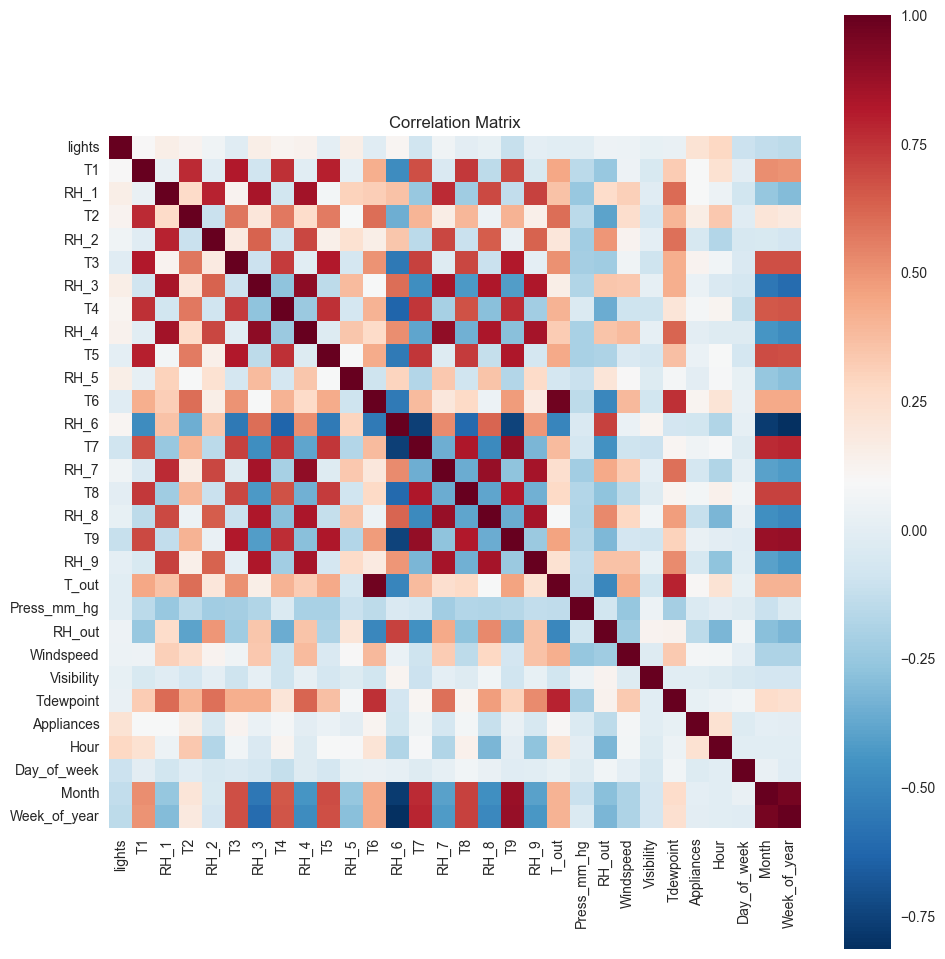

In [21]:
encoded_corr_matrix = reshaped_training_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(encoded_corr_matrix, annot=False, fmt=".2f", square=True, cmap='RdBu_r')  
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Data preparation

In [22]:
# Use the process_train_data function in a FunctionTransformer object can use it as part of a pipeline
encoder_transformer = FunctionTransformer(process_train_data)

# The PowerTransformer makes our data more normal or standard for better use in certain statistical models. 
# It finds the best way to transform the "Appliances" data to make it follow a bell curve (normal distribution). 
# This can help improve the accuracy of our machine learning models.
pt = PowerTransformer()
pt.fit(train_data[["Appliances"]])


train_data["Appliances"] = pt.transform(train_data[["Appliances"]])

y = train_data["Appliances"]

X = train_data.drop("Appliances", axis=1)

X.head()

,date,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Hour,Day_of_week,Month,Week_of_year
0,2016-01-11 17:00:00,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,92.0,7.000000,63.000000,5.3,13.275433,13.275433,17,0,1,2
1,2016-01-11 17:10:00,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,92.0,6.666667,59.166667,5.2,18.606195,18.606195,17,0,1,2
2,2016-01-11 17:20:00,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,92.0,6.333333,55.333333,5.1,28.642668,28.642668,17,0,1,2
3,2016-01-11 17:30:00,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,92.0,6.000000,51.500000,5.0,45.410389,45.410389,17,0,1,2
4,2016-01-11 17:40:00,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,92.0,5.666667,47.666667,4.9,10.084097,10.084097,17,0,1,2


### Helper functions

In [23]:
def print_model_scores(model, X_train, y_train, X_test, y_test):
    train_mae = calculate_model_score(model, X_train, y_train)
    test_mae = calculate_model_score(model, X_test, y_test)

    print(f"Training MAE: {train_mae}")
    print(f"Test MAE: {test_mae}")

def convert_predictions(predictions):
    return pt.inverse_transform(predictions.reshape(-1, 1))
    
def calculate_model_score(model, X, y):
    return mean_absolute_error(convert_predictions(y.array), convert_predictions(model.predict(X)))

### Split data into train and test


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)

## DecisionTreeRegressor

### Bayesian Search

I use inverse because transforming predictions ensures scores align with actual data values, thereby enhancing the accuracy and interpretability of model performance.


In [ ]:

pipe = make_pipeline(encoder_transformer, StandardScaler(), DecisionTreeRegressor(random_state=42))

# param_space = {
#     "dt__max_depth": Integer(1, 20),
#     "dt__min_samples_split": Real(0.001, 0.5, 'log-uniform'), 
#     "dt__min_samples_leaf": Real(0.001, 0.5, 'log-uniform'),  
# }

param_space = {
    "decisiontreeregressor__max_depth": Integer(1, 110, prior="uniform"),
    "decisiontreeregressor__min_samples_split": Integer(2, 10, prior="uniform"),
    "decisiontreeregressor__min_samples_leaf": Integer(1, 5, prior="uniform")
    }
# param_space = {
#     "decisiontreeregressor__max_depth": Integer(1, 3, prior="uniform"),
#     "decisiontreeregressor__min_samples_split": Integer(2, 4, prior="uniform"),
#     "decisiontreeregressor__min_samples_leaf": Integer(1, 3, prior="uniform")
#     }


scoring = make_scorer(lambda y, y_pred: mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))), greater_is_better=False)

# Bayesian optimization
opt_bs = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_space,
    cv=5,
    n_iter=50,  # reduce if it takes too long
    n_jobs=-1,  # use all processors
    scoring=scoring,
    # scoring='neg_mean_squared_error',
    return_train_score=True,
    # random_state=42  # for reproducibility
)

opt_bs.fit(X_train, y_train)

In [ ]:
print(f"Here the Best parameters:")

for param in opt_bs.best_params_.keys():
    print(f"    {param}: {opt_bs.best_params_[param]}")

bs_optimal_tree = opt_bs.best_estimator_

print_model_scores(bs_optimal_tree, X_train, y_train, X_test, y_test)

# Grid Search

In [25]:
pipe = make_pipeline(encoder_transformer, StandardScaler(), DecisionTreeRegressor())


param_space = {
    "decisiontreeregressor__max_depth": np.arange(65, 76),
    "decisiontreeregressor__min_samples_split": np.arange(8, 15),
    "decisiontreeregressor__min_samples_leaf": np.arange(1, 3)
    }

scoring = make_scorer(lambda y, y_pred: mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))), greater_is_better=False)

opt_dt_gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_space,
    cv=5,
    refit=True,
    n_jobs=-1,
    scoring=scoring,
    return_train_score=True
)

opt_dt_gs.fit(X_train, y_train)

# Get the fitted pipeline from the grid search
fitted_pipe = opt_dt_gs.best_estimator_

# Get the fitted scaler from the pipeline
scaler = fitted_pipe.named_steps['standardscaler']

/Users/erdo/Desktop/vub-mac-pro-14/second-year/retake/ml/project/vub-ml-2023-predicting-energy-consumption/ml_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/erdo/Desktop/vub-mac-pro-14/second-year/retake/ml/project/vub-ml-2023-predicting-energy-consumption/ml_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/erdo/Desktop/vub-mac-pro-14/second-year/retake/ml/project/vub-ml-2023-predicting-energy-consumption/ml_env/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/Users/erdo/Desktop/vub-mac-pro-14/second-year/retake/ml/project/vub-ml-2023-predicting-energy-consumption/ml_env/lib/python3.11/site-packages/sklearn/bas

In [26]:
print(f"Here the Best parameters:")

for param in opt_dt_gs.best_params_.keys():
    print(f"    {param}: {opt_dt_gs.best_params_[param]}")

gs_optimal_tree = opt_dt_gs.best_estimator_

print_model_scores(gs_optimal_tree, X_train, y_train, X_test, y_test)

Here the Best parameters:
    decisiontreeregressor__max_depth: 67
    decisiontreeregressor__min_samples_leaf: 2
    decisiontreeregressor__min_samples_split: 14
Training MAE: 20.47023492562197
Test MAE: 39.654564310939996


In [ ]:
print(X_train.dtypes)

In [27]:
best_model_dt_pipe = make_pipeline(
    encoder_transformer,
    StandardScaler(),
    DecisionTreeRegressor(
        max_depth=67,
        min_samples_leaf=2,
        min_samples_split=8,
        random_state=42  
    )
)

best_model_dt_pipe.fit(X_train, y_train)

y_pred_transformed = best_model_dt_pipe.predict(X_test)

# Apply inverse transformation
y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1))

# Compute MAE on the original scale
mae = mean_absolute_error(pt.inverse_transform(y_test.to_numpy().reshape(-1, 1)), y_pred)
print('Test MAE:', mae)



Test MAE: 40.38797907995475


### Model Analysis

<Axes: >

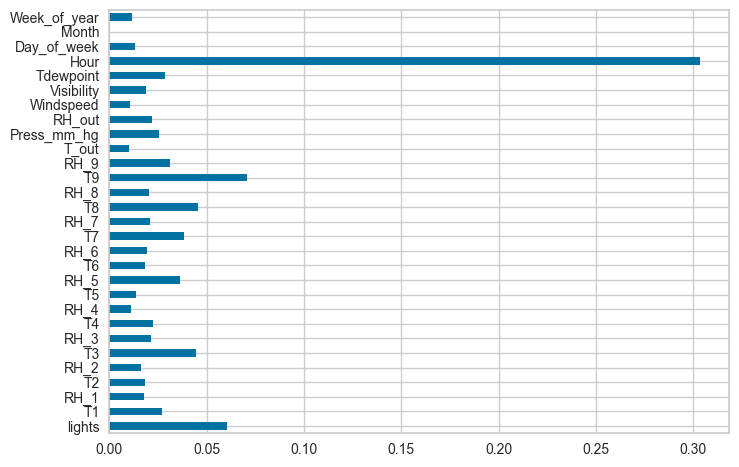

In [28]:
feature_importances = pd.Series(gs_optimal_tree[2].feature_importances_, index=gs_optimal_tree[1].feature_names_in_)
feature_importances.plot.barh()

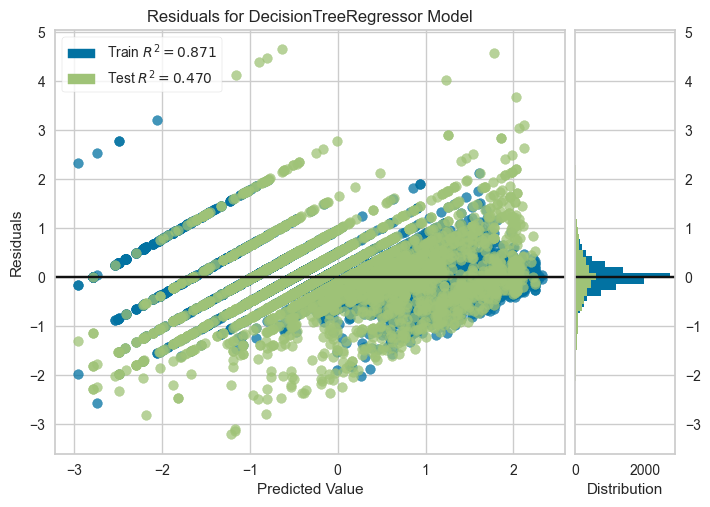

<Axes: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [29]:
residual = ResidualsPlot(gs_optimal_tree)
residual.fit(X_train, y_train)
residual.score(X_test, y_test)
residual.show()

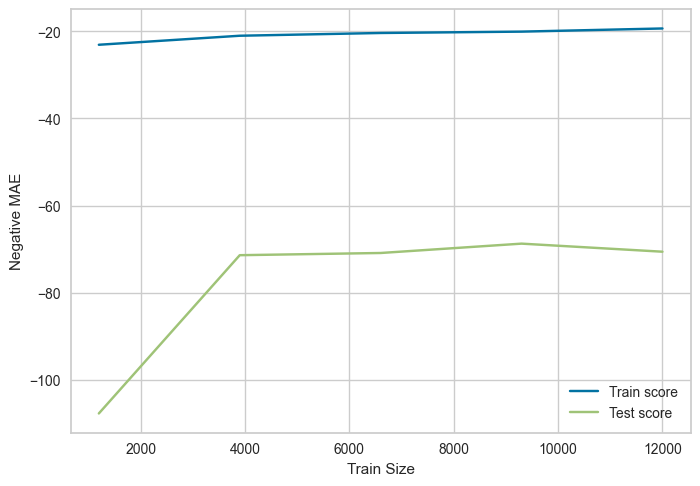

In [30]:
scoring = make_scorer(lambda y, y_pred: mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))), greater_is_better=False)

train_sizes, train_scores, test_scores, _, _ = learning_curve(gs_optimal_tree, X, y, cv=5, return_times=True, scoring=scoring)

plt.plot(train_sizes,np.mean(train_scores,axis=1), label="Train score")
plt.plot(train_sizes,np.mean(test_scores,axis=1), label="Test score")
plt.xlabel("Train Size")
plt.ylabel("Negative MAE")
plt.legend()
plt.show()

## XGBRegressor

### Bayesian Search

In [ ]:
xgb_pipe_bs = make_pipeline(encoder_transformer, StandardScaler(), xgb.XGBRegressor())

param_space = {
        "xgbregressor__n_estimators": Integer(100, 4000, prior="uniform"),
        "xgbregressor__max_depth": Integer(1, 10, prior="uniform"),
        "xgbregressor__learning_rate": Real(0.001, 1, prior="log-uniform"),
        "xgbregressor__subsample": Real(0.5, 1, prior="log-uniform"),
        "xgbregressor__colsample_bytree": Real(0.5, 1, prior="log-uniform"),
        "xgbregressor__colsample_bylevel" : Real(0.5, 1, prior="log-uniform"),
        "xgbregressor__gamma": Real(0, 10, prior="uniform"),
        "xgbregressor__reg_lambda": Real(0, 10, prior="uniform"),
        "xgbregressor__reg_alpha": Real(0, 10, prior="uniform"),
        "xgbregressor__min_child_weight": Integer(1, 10, prior="uniform")
    }

# scoring = make_scorer(lambda y, y_pred: mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))), greater_is_better=False)
def robust_mae(y, y_pred):
    try:
        score = mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), 
                                    pt.inverse_transform(np.array(y_pred).reshape(-1, 1)))
    except Exception as e:
        print(f"Error during scoring: {e}")
        score = 1e6  # use a large number instead of infinity
    return score

scoring = make_scorer(robust_mae, greater_is_better=False)

opt_bs_xgb = BayesSearchCV(
    estimator=xgb_pipe_bs,
    search_spaces=param_space,
    n_iter=100,
    scoring=scoring,
    cv=3,
    refit=True,
    n_jobs=-1,
)

opt_bs_xgb.fit(X_train, y_train)

In [ ]:
print(f"Here the Best parameters:")

for param in opt_bs_xgb.best_params_.keys():
    print(f"    {param}: {opt_bs_xgb.best_params_[param]}")

gs_optimal_tree = opt_bs_xgb.best_estimator_

print_model_scores(gs_optimal_tree, X_train, y_train, X_test, y_test)

### Random Search

We couldnt use grid search cv because time complexity is too high.

In [ ]:
xgb_pipe = make_pipeline(encoder_transformer, StandardScaler(), xgb.XGBRegressor())

param_space = {
    "xgbregressor__n_estimators": randint(3500, 4000),
    "xgbregressor__max_depth": randint(3, 10),
    "xgbregressor__learning_rate": uniform(0.005, 0.01),
    "xgbregressor__subsample": uniform(0.5, 0.6),
    "xgbregressor__colsample_bytree": uniform(0.9, 1.0),
    "xgbregressor__colsample_bylevel": uniform(0.5, 0.6),
    "xgbregressor__gamma": uniform(0, 0.5),
    "xgbregressor__reg_lambda": uniform(1.0, 3.0),
    "xgbregressor__reg_alpha": uniform(0, 0.5),
    "xgbregressor__min_child_weight": randint(1, 10)
}

scoring = make_scorer(lambda y, y_pred: mean_absolute_error(pt.inverse_transform(np.array(y).reshape(-1, 1)), pt.inverse_transform(np.array(y_pred).reshape(-1, 1))), greater_is_better=False)

opt_rs_xgb = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_space,
    scoring=scoring,
    n_iter=50, # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    cv=3,
    refit=True,
    random_state=42,
    n_jobs=-1
)


opt_rs_xgb.fit(X_train, y_train)


In [ ]:
print(f"Here the Best parameters:")

for param in opt_rs_xgb.best_params_.keys():
    print(f"    {param}: {opt_rs_xgb.best_params_[param]}")

gs_optimal_tree = opt_rs_xgb.best_estimator_

print_model_scores(gs_optimal_tree, X_train, y_train, X_test, y_test)

In [ ]:
best_model_xgb_pipe = make_pipeline(
    encoder_transformer,
    StandardScaler(),
    xgb.XGBRegressor(
        colsample_bylevel=0.7466222079909388,
        colsample_bytree=0.9330507329005484,
        gamma=0.1725356240133415,
        learning_rate=0.011343513447013637,
        max_depth=8,
        min_child_weight=2,
        n_estimators=3552,
        reg_alpha=0.2447263801387815,
        reg_lambda=3.956951362331802,
        subsample=0.6452331629069002,
        random_state=42
    )
)

best_model_xgb_pipe.fit(X_train, y_train)

y_pred_transformed = best_model_xgb_pipe.predict(X_test)

# Apply inverse transformation
y_pred = pt.inverse_transform(y_pred_transformed.reshape(-1, 1))

# Compute MAE on the original scale
mae = mean_absolute_error(pt.inverse_transform(y_test.to_numpy().reshape(-1, 1)), y_pred)
print('Test MAE:', mae)

### Building a first submission

For a first submission, let's just take the average consumption for the E-scooter count of the training set, and use this value for all test samples:

Create a unique filename based on timestamp:

In [41]:
def generate_unique_filename(basename, file_ext):
    """Adds a timestamp to filenames for easier tracking of submissions, models, etc."""
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    return basename + '_' + timestamp + '.' + file_ext

Let's create our pandas dataframe and write it to csv. You can submit this file to Kaggle. It is very important that your submission also has the 'Id' and 'Predicted' column, with the Ids corresponding to the index of the test dataset. Normally your test data does not get mixed when doing predictions, so this should not be a problem.

In [42]:
def generate_kaggle_submission(model):
    kaggle_data = pd.read_csv("test.csv")
    # print(kaggle_data)
    # kaggle_data_processed = process_test_data(kaggle_data,scaler)
    predictions = model.predict(kaggle_data)
    predictions = pt.inverse_transform(predictions.reshape(-1, 1))
    submission = pd.DataFrame(data=predictions, columns=["Appliances"])
    submission.reset_index(inplace=True)
    submission = submission.rename(columns = {'index':'Id'})
    # Generate a unique filename and save the submission DataFrame as a csv file
    submission.to_csv(data_folder + generate_unique_filename("Erdogan_Submission", ".csv"), index=False)

    print("Done")


In [43]:
generate_kaggle_submission(best_model_dt_pipe)

Done
